In [1]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import gc
import math
from IPython.display import clear_output
import time
import os
import matplotlib.pyplot as plt
import glob
import pathlib

In [ ]:
# Authors: Sankalp Doshi, Hyunjoon Kweon, Benjamin Wang
# Group Project for CSDS 313

In [2]:
# Instance Normalization

class InstanceNormalization(tf.keras.layers.Layer):

    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.compat.v1.truncated_normal_initializer(1., 0.02),
            trainable=True)

        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer=tf.constant_initializer(0),
            trainable=True)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

In [3]:
def c7s1_k(k, initializer='glorot_uniform', act='relu'):
    '''
    7×7 Convolution-InstanceNorm-ReLU layer with k filters and stride 1.
    '''
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Conv2D(filters=k, kernel_size=(7,7), strides=(1,1), padding='same', \
                                     kernel_initializer=initializer, use_bias=False))
    model.add(InstanceNormalization())
    model.add(tf.keras.layers.Activation(act))
    
    return model

In [4]:
def dk(k, initializer):
    '''
    3 × 3 Convolution-InstanceNorm-ReLU layer with k filters and stride 2 
    '''
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=k, kernel_size=(3,3), strides=(2,2), padding='same', \
                                     kernel_initializer=initializer, use_bias=False))
    model.add(InstanceNormalization())
    model.add(tf.keras.layers.ReLU())
    
    return model

In [5]:
class Rk(tf.keras.Model):
    def __init__(self, k, initializer):
        super(Rk, self).__init__()
        self.initializer = initializer
        self.k = k
        
        self.conv1 = tf.keras.layers.Conv2D(filters=self.k, kernel_size=(3,3), kernel_initializer=self.initializer, \
                                       padding='valid', use_bias=False)
        
        self.conv2 = tf.keras.layers.Conv2D(filters=self.k, kernel_size=(3,3), kernel_initializer=self.initializer, \
                                       padding='valid', use_bias=False)
        
        
        self.instnorm1 = InstanceNormalization()
        self.instnorm2 = InstanceNormalization()
        
        self.reluact1 = tf.keras.layers.ReLU()
        self.reluact2 = tf.keras.layers.ReLU()
        
    def call(self, input_data):
        pad_input = tf.pad(input_data, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
        x = self.conv1(pad_input)
        x = self.instnorm1(x)
        x = self.reluact1(x)

        pad_input2 = tf.pad(x, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
        y = self.conv2(pad_input2)
        y = self.instnorm2(y)

        out = x + y 
        out = self.reluact2(out)

        return out

In [6]:
def uk(k, initializer):
    '''
    3 × 3 fractional-strided-Convolution-InstanceNorm-ReLU layer with k filters and stride 1/2
    '''
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2DTranspose(filters=k, kernel_size=(3,3), strides=(2,2), padding='same', \
                                     kernel_initializer=initializer, use_bias=False))
    model.add(InstanceNormalization())
    model.add(tf.keras.layers.ReLU())
    
    return model

In [7]:
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.initializer = tf.compat.v1.truncated_normal_initializer(0., 0.02)   
        
        self.en1 = c7s1_k(64, self.initializer)
        self.en2 = dk(128, self.initializer)
        self.en3 = dk(256, self.initializer)
        
        self.res1 = Rk(256, self.initializer)
        self.res2 = Rk(256, self.initializer)
        self.res3 = Rk(256, self.initializer)
        self.res4 = Rk(256, self.initializer)
        self.res5 = Rk(256, self.initializer)
        self.res6 = Rk(256, self.initializer)
        
        self.de3 = uk(128, self.initializer)
        self.de2 = uk(64, self.initializer)
        self.de1 = c7s1_k(3, self.initializer, 'tanh')
        
    def call(self, input_tensor):
        x = self.en1(input_tensor)
        x = self.en2(x)
        x = self.en3(x)
        
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = self.res5(x)
        x = self.res6(x)
        
        x = self.de3(x)
        x = self.de2(x)
        x = self.de1(x)
        
        return x

In [8]:
input_dim = (128,128,3)
input_data = tf.random.uniform(shape=(1,128,128,3))

In [9]:
model = Generator()
_ = model(input_data)
model.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (1, 128, 128, 64)         9536      
                                                                 
 sequential_1 (Sequential)   (1, 64, 64, 128)          73984     
                                                                 
 sequential_2 (Sequential)   (1, 32, 32, 256)          295424    
                                                                 
 rk (Rk)                     multiple                  1180672   
                                                                 
 rk_1 (Rk)                   multiple                  1180672   
                                                                 
 rk_2 (Rk)                   multiple                  1180672   
                                                                 
 rk_3 (Rk)                   multiple                  11

In [10]:
def Ck(k, stride, initializer, do_norm=True):
    '''
    4 × 4 Convolution-InstanceNorm-LeakyReLU layer with k filters and stride 2.
    '''
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=k, kernel_size=(4,4), strides=stride, padding='same', \
                                     kernel_initializer=initializer, use_bias=False))
    if do_norm:
        model.add(InstanceNormalization())
    
    model.add(tf.keras.layers.LeakyReLU(0.2))
    
    return model

In [11]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.initializer = tf.compat.v1.truncated_normal_initializer(0., 0.02)   
        
        self.c64 = Ck(64, (2,2), self.initializer, False)
        self.c128 = Ck(128, (2,2), self.initializer)
        self.c256 = Ck(256, (2,2), self.initializer)
        self.c512 = Ck(512, (1,1), self.initializer)
        
        self.conv = tf.keras.layers.Conv2D(filters=1, kernel_size=(4,4), strides=(1,1), padding='same',
                                           kernel_initializer=self.initializer, use_bias=False)
        
    def call(self, input_tensor):
        input_tensor = input_tensor + tf.random.normal(shape=tf.shape(input_tensor), mean=0.0, stddev=0.1, dtype=tf.float32)
        x = self.c64(input_tensor)
        x = self.c128(x)
        x = self.c256(x)
        x = self.c512(x)
        
        x = self.conv(x)
        
        return x   

In [12]:
model = Discriminator()
_ = model(input_data)
model.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (1, 64, 64, 64)           3072      
                                                                 
 sequential_7 (Sequential)   (1, 32, 32, 128)          131328    
                                                                 
 sequential_8 (Sequential)   (1, 16, 16, 256)          524800    
                                                                 
 sequential_9 (Sequential)   (1, 16, 16, 512)          2098176   
                                                                 
 conv2d_20 (Conv2D)          multiple                  8192      
                                                                 
Total params: 2,765,568
Trainable params: 2,765,568
Non-trainable params: 0
_________________________________________________________________


In [13]:
del input_data, input_dim

In [14]:
LAMBDA = 10
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def D_loss(real, generated):
    return (loss(tf.ones_like(real), real) + loss(tf.zeros_like(generated), generated)) * 0.5

def G_loss(generated):
    return loss(tf.ones_like(generated), generated)

def Similarity_loss(image1, image2):
    return tf.reduce_mean(tf.abs(image1 - image2))

In [15]:
# Code credit: https://www.tensorflow.org/tutorials/generative/cyclegan
# Generate image from particular model when feeding test_input as input
def generate_images(model, test_input):
    prediction = model(test_input)
    
    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i]*0.5+0.5)
        plt.axis('off')
    plt.show()

In [16]:
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Setup Dy loss
        fake_y = G(real_x, training=True)
        disc_fake_y = Dy(fake_y, training=True)
        dis_y_loss = D_loss(Dy(real_y, training=True), disc_fake_y)

        with tape.stop_recording():
            Dy_gradients = tape.gradient(dis_y_loss, Dy.trainable_variables)
            Dy_optimizer.apply_gradients(zip(Dy_gradients, Dy.trainable_variables))

        # Setup Dx loss
        fake_x = F(real_y, training=True)
        disc_fake_x = Dx(fake_x, training=True)
        dis_x_loss = D_loss(Dx(real_x, training=True), disc_fake_x)

        with tape.stop_recording():
            Dx_gradients = tape.gradient(dis_x_loss, Dx.trainable_variables)
            Dx_optimizer.apply_gradients(zip(Dx_gradients, Dx.trainable_variables))

        # Setup adversarial losses
        gen_g_adv_loss = G_loss(disc_fake_y)
        gen_f_adv_loss = G_loss(disc_fake_x)

        # Setup cycle losses
        cyc_x = F(fake_y, training=True)
        cyc_x_loss = Similarity_loss(real_x, cyc_x)

        cyc_y = G(fake_x, training=True)
        cyc_y_loss =  Similarity_loss(real_y, cyc_y)

        # Setup identity losses
        id_x = F(real_x, training=True)
        id_x_loss = Similarity_loss(real_x, id_x)

        id_y = G(real_y, training=True)
        id_y_loss = Similarity_loss(real_y, id_y)

        # Finalize generator losses and calc gradients
        gen_g_loss = gen_g_adv_loss + (cyc_x_loss + cyc_y_loss) * LAMBDA + id_y_loss * 0.5 * LAMBDA
        gen_f_loss = gen_f_adv_loss + (cyc_x_loss + cyc_y_loss) * LAMBDA + id_x_loss * 0.5 * LAMBDA

        with tape.stop_recording():
            G_gradients = tape.gradient(gen_g_loss, G.trainable_variables)
            G_optimizer.apply_gradients(zip(G_gradients, G.trainable_variables))

            F_gradients = tape.gradient(gen_f_loss, F.trainable_variables)
            F_optimizer.apply_gradients(zip(F_gradients, F.trainable_variables))
    
    return gen_g_loss,gen_f_loss,dis_x_loss,dis_y_loss

In [17]:
# Download dataset from original site.

data_dir = tf.keras.utils.get_file(fname='monet2photo.zip', origin='https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/monet2photo.zip', \
                        extract=True, archive_format='zip', cache_dir='./')
data_dir = tf.keras.utils.get_file(fname='cezanne2photo.zip', origin='https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/cezanne2photo.zip', \
                        extract=True, archive_format='zip', cache_dir='./')
data_dir = tf.keras.utils.get_file(fname='vangogh2photo.zip', origin='https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/vangogh2photo.zip', \
                        extract=True, archive_format='zip', cache_dir='./')
data_dir = tf.keras.utils.get_file(fname='ukiyoe2photo.zip', origin='https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/ukiyoe2photo.zip', \
                        extract=True, archive_format='zip', cache_dir='./')

In [18]:
data_dir = pathlib.Path('./datasets')
print('List of folder inside dataset')
ldir = []
for i in list(os.listdir(str(data_dir))):
    try:
        if i.split('.')[1]:
            continue
    except:
        ldir.append(i)
ldir

List of folder inside dataset


['cezanne2photo', 'monet2photo', 'ukiyoe2photo', 'vangogh2photo']

In [19]:
# Each dataset folder contain
os.listdir(str(data_dir)+'/'+ldir[0])

['testA', 'testB', 'trainA', 'trainB']

In [20]:
TotalImg_A = 0
TotalImg_B = 0
for i in range(len(ldir)):
    dataset_sub = pathlib.Path(str(data_dir)+'/'+ldir[i]+'/')
    
    print('-------- For this folder:',dataset_sub,'--------')
    print('Number of images contain trainA')
    len_A = len(list(dataset_sub.glob('trainA/*')))
    TotalImg_A += len_A
    print(len_A)
    print('\nNumber of images contain trainB')
    len_B = len(list(dataset_sub.glob('trainB/*')))
    print(len_B)

TotalImg_B += len_B
    
list_1 = tf.data.Dataset.list_files(str(data_dir)+'/'+ldir[0]+'/trainA/*')
list_2 = tf.data.Dataset.list_files(str(data_dir)+'/'+ldir[1]+'/trainA/*')
list_A = list_1.concatenate(list_2)
list_3 = tf.data.Dataset.list_files(str(data_dir)+'/'+ldir[2]+'/trainA/*')
list_A = list_A.concatenate(list_3)
list_4 = tf.data.Dataset.list_files(str(data_dir)+'/'+ldir[3]+'/trainA/*')
list_A = list_A.concatenate(list_4)

list_B = tf.data.Dataset.list_files(str(data_dir)+'/'+ldir[0]+'/trainB/*')
del list_1, list_2, list_3, list_4

-------- For this folder: datasets\cezanne2photo --------
Number of images contain trainA
525

Number of images contain trainB
6287
-------- For this folder: datasets\monet2photo --------
Number of images contain trainA
1072

Number of images contain trainB
6287
-------- For this folder: datasets\ukiyoe2photo --------
Number of images contain trainA
562

Number of images contain trainB
6287
-------- For this folder: datasets\vangogh2photo --------
Number of images contain trainA
400

Number of images contain trainB
6287


In [21]:
print('Total Number of Images in trainA (artist)',TotalImg_A)
print('Total Number of Images in trainB (photo)',TotalImg_B)

Total Number of Images in trainA (artist) 2559
Total Number of Images in trainB (photo) 6287


In [22]:
BATCH_SIZE = 1
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [23]:
print('List of files from trainA directory')
for f in list_A.take(5):
    print(f.numpy())
    
print('\nList of files from trainB directory')    
for f in list_B.take(5):
    print(f.numpy())  

List of files from trainA directory
b'datasets\\cezanne2photo\\trainA\\00447.jpg'
b'datasets\\cezanne2photo\\trainA\\00578.jpg'
b'datasets\\cezanne2photo\\trainA\\00479.jpg'
b'datasets\\cezanne2photo\\trainA\\00255.jpg'
b'datasets\\cezanne2photo\\trainA\\00471.jpg'

List of files from trainB directory
b'datasets\\cezanne2photo\\trainB\\2015-03-21 15_49_02.jpg'
b'datasets\\cezanne2photo\\trainB\\2016-12-24 10_41_51.jpg'
b'datasets\\cezanne2photo\\trainB\\2016-05-30 11_23_32.jpg'
b'datasets\\cezanne2photo\\trainB\\2015-12-09 15_20_22.jpg'
b'datasets\\cezanne2photo\\trainB\\2016-03-15 06_31_00.jpg'


In [24]:
def random_crop(image):
    cropped_image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
    
    return cropped_image

def random_jitter(image):
    # resizing to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # randomly cropping to 256 x 256 x 3
    image = random_crop(image)

    # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image

def normalize(img):
    img = tf.cast(img, tf.float32)
    img = (img / 127.5) - 1
    return img

def read_file(filename):
    # read the filename
    x = tf.io.read_file(filename)
    # Convert into color image
    x = tf.image.decode_jpeg(x, channels=3)
    x = random_jitter(x)
    x = normalize(x)
    # return image with specific image width and height
    return tf.image.resize(x, [IMG_WIDTH//2, IMG_HEIGHT//2])

print('Print the size of a image from trainA folder')
trainA = list_A.map(read_file, num_parallel_calls=-1)
for i in trainA.take(1):
    print(i.numpy().shape)
    
print('\nPrint the size of a image from trainB folder')
trainB = list_B.map(read_file, num_parallel_calls=-1)
for i in trainB.take(1):
    print(i.numpy().shape)

Print the size of a image from trainA folder
(128, 128, 3)

Print the size of a image from trainB folder
(128, 128, 3)


In [25]:
Total_Img = math.floor(min(TotalImg_A,TotalImg_B)/100) * 100

trainA = trainA.shuffle(Total_Img).batch(BATCH_SIZE)
trainB = trainB.shuffle(Total_Img).batch(BATCH_SIZE)

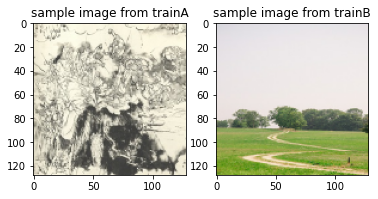

In [26]:
sampleA = next(iter(trainA))
sampleB = next(iter(trainB))

plt.subplot(121)
plt.imshow(sampleA[0]*0.5+0.5)
plt.title('sample image from trainA')
plt.subplot(122)
plt.imshow(sampleB[0]*0.5+0.5)
plt.title('sample image from trainB')
plt.show()

In [27]:
print('Create instance of all models and save initial weights when model instanstiad: G, F, Dx, Dy')
inp_shape=(IMG_WIDTH//2,IMG_HEIGHT//2,3)
inp = tf.keras.Input(shape=inp_shape)

G = Generator()
_ = G(inp)
G.save_weights('./weights/G_Weights')

F = Generator()
_ = F(inp)
F.save_weights('./weights/F_Weights')

Dx = Discriminator()
_ = Dx(inp)
Dx.save_weights('./weights/Dx_Weights')

Dy = Discriminator()
_ = Dy(inp)
Dy.save_weights('./weights/Dy_Weights')

del G, F, Dx, Dy

Create instance of all models and save initial weights when model instanstiad: G, F, Dx, Dy


In [28]:
print('Reload the initial weights')
inp_shape=(IMG_WIDTH//2,IMG_HEIGHT//2,3)
G = Generator()
G.load_weights('./weights/G_Weights')
F = Generator()
F.load_weights('./weights/F_Weights')
Dx = Discriminator()
Dx.load_weights('./weights/Dx_Weights')
Dy = Discriminator()
Dy.load_weights('./weights/Dy_Weights')


# A per paper, it used lamda = 10
lr = 0.0002

print('optimizer defining...')
# Define Optimizer for G and F model
G_optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.5)
F_optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.5)
# Define Optimizer for Dx and Dy model
Dx_optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.5)
Dy_optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.5)

Reload the initial weights
optimizer defining...


In [ ]:
deltalr = lr/100
log_dir="logs/"

G_Loss_M = tf.metrics.Mean()
F_Loss_M = tf.metrics.Mean()
Dx_Loss_M = tf.metrics.Mean()
Dy_Loss_M = tf.metrics.Mean()

summary_writer_epoch = tf.summary.create_file_writer(log_dir + "train_per_epoch/")
summary_writer_steps = tf.summary.create_file_writer(log_dir + "train_per_step/")

for epoch in range(200):
    tf.keras.backend.clear_session()
    
    l_G = []
    l_F = []
    l_Dy = []
    l_Dx = []

    # After 100 epoch learning rate set to linear decay
    if epoch >= 100:
        lr = lr - deltalr
        # Update learning rate in Optimizer for G and F model
        tf.keras.backend.set_value(G_optimizer.lr, lr)
        tf.keras.backend.set_value(F_optimizer.lr, lr)
        # Update learning rate in Optimizer for Dx and Dy model
        tf.keras.backend.set_value(Dx_optimizer.lr, lr)
        tf.keras.backend.set_value(Dy_optimizer.lr, lr)
        
    start = time.time()
    n = 0
    for image_x, image_y in zip(trainA, trainB):
        total_gen_g_loss,total_gen_f_loss,disc_x_loss,disc_y_loss = train_step(image_x, image_y)
        
        l_G.append(total_gen_g_loss)
        l_F.append(total_gen_f_loss)
        l_Dx.append(disc_x_loss)
        l_Dy.append(disc_y_loss)
        
        if n % 100 == 0:
            print('.', end='')
            with summary_writer_steps.as_default():
                tf.summary.scalar('Total_Gloss', total_gen_g_loss, step=epoch*Total_Img+n)
                tf.summary.scalar('Total_Floss', total_gen_f_loss, step=epoch*Total_Img+n)
                tf.summary.scalar('Dx_loss', disc_x_loss, step=epoch*Total_Img+n)
                tf.summary.scalar('Dy_loss', disc_y_loss, step=epoch*Total_Img+n)
                
        n+=1
        
    # Clear the output
    clear_output(wait=True)
    # generate image based on Generator G
    generate_images(G, sampleA)
    # generate image based on Generator F
    generate_images(F, sampleB)
    
    
    G_Loss_M.update_state(l_G)
    F_Loss_M.update_state(l_F)
    Dx_Loss_M.update_state(l_Dx)
    Dy_Loss_M.update_state(l_Dy)
    
    with summary_writer_epoch.as_default():
        tf.summary.scalar('Total_Gloss', G_Loss_M.result().numpy(), step=epoch)
        tf.summary.scalar('Total_Floss', F_Loss_M.result().numpy(), step=epoch)
        tf.summary.scalar('Dx_loss', Dx_Loss_M.result().numpy(), step=epoch)
        tf.summary.scalar('Dy_loss', Dy_Loss_M.result().numpy(), step=epoch)
        
    G_Loss_M.reset_states()
    F_Loss_M.reset_states()
    Dx_Loss_M.reset_states()
    Dy_Loss_M.reset_states()
    
    if (epoch+1) % 10 == 0:
        print('Saving weights')
        G.save_weights('./train/G_Weights_epoch'+str(epoch+1))
        F.save_weights('./train/F_Weights_epoch'+str(epoch+1))
        Dx.save_weights('./train/Dx_Weights_epoch'+str(epoch+1))
        Dy.save_weights('./train/Dy_Weights_epoch'+str(epoch+1))
    
    print ('Time taken for epoch {} is {} sec\n'.format(epoch+1, time.time()-start))

...

In [ ]:
G.save('G_Model')
F.save('F_Model')
Dx.save('Dx_Model')
Dy.save('Dy_Model')

In [ ]:
for inp in trainB.take(5):
    generate_images(F, inp)